In [1]:
import sys, os, h5py
import numpy as np
import pandas as pd
from numpy import genfromtxt  
import nibabel as nb
from brainspace.mesh import mesh_elements
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from brainstat.mesh.data import mesh_smooth
import plot_funcs
import warnings
warnings.filterwarnings("ignore")

### get surface info for plots..

In [2]:
surf_lh, surf_rh = load_conte69()

# write surface coordinates and triangles in a dictionary
lh_coord = np.array(mesh_elements.get_points(surf_lh)).T
rh_coord = np.array(mesh_elements.get_points(surf_rh)).T
lh_tri = np.array(mesh_elements.get_cells(surf_lh))
rh_tri = np.array(mesh_elements.get_cells(surf_rh))

D = {}
D['coord'] = np.concatenate((lh_coord, rh_coord), axis=1)         # (3, 64984)     
D['tri'] = np.concatenate((lh_tri, rh_tri + lh_coord.shape[1]))   # (129960, 3)

# labeling
labeling_file = '../data/tout_group/glasser.csv' 
labeling = genfromtxt(labeling_file)

# medial wall mask
mask = labeling != 0 
mymask = np.ones((64984,)).astype('bool')
mymask[np.where(mask == False)[0]] = False
mymask[np.where(mask == False)[0] + 32492] = False


## Hippocampal-isocortical connectivity analysis for subfields

### LSUB - cortex

In [3]:
fname = '../data/tout_group/Tvals_cortex709_LSUB.h5'

h = h5py.File((fname), 'r')
Tdata = np.array(h['data'])
h.close()

Tdata = Tdata.reshape(Tdata.shape[1],)

Tsmoo = mesh_smooth(Tdata.reshape(len(Tdata),1).T, D, 3)
Tsmoo = Tsmoo.reshape(Tsmoo.shape[1],)
Tsmoo[Tsmoo<20] = np.nan
Tsmoo[np.where(mymask == False)] = np.nan

print(Tsmoo.shape)


(64984,)


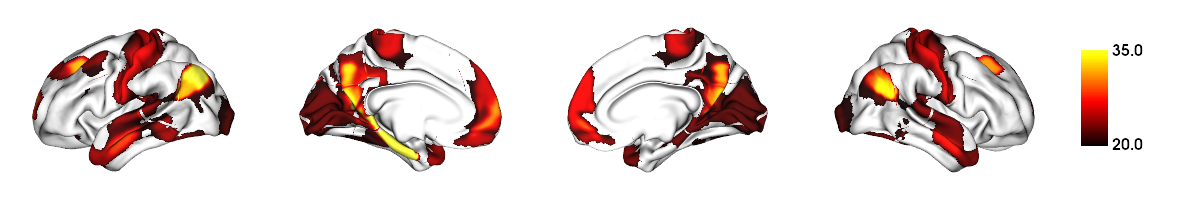

In [4]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = Tsmoo,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = plot_funcs.hotcolors, 
                 color_bar = True,
                 color_range = (20, 35),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/Tvals_cortex_LSUB.svg'
                 )

### LCA - cortex

In [5]:
fname = '../data/tout_group/Tvals_cortex709_LCA.h5'

h = h5py.File((fname), 'r')
Tdata = np.array(h['data'])
h.close()

Tdata = Tdata.reshape(Tdata.shape[1],)

Tsmoo = mesh_smooth(Tdata.reshape(len(Tdata),1).T, D, 3)
Tsmoo = Tsmoo.reshape(Tsmoo.shape[1],)

Tsmoo[Tsmoo<20] = np.nan
Tsmoo[np.where(mymask == False)] = np.nan

print(Tsmoo.shape)

(64984,)


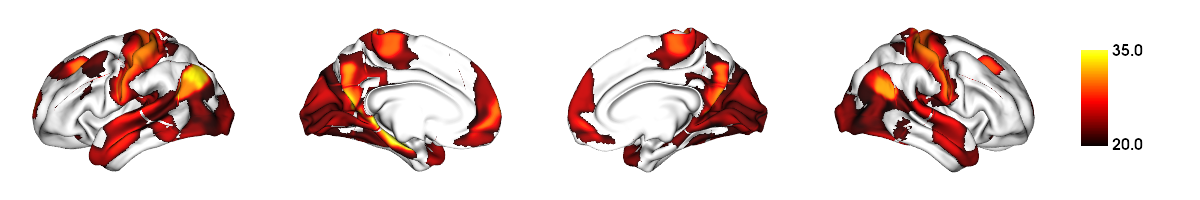

In [6]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = Tsmoo,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = plot_funcs.hotcolors,
                 color_bar = True,
                 color_range = (20, 35),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/Tvals_cortex_LCA.svg'
                 )

### LDG - cortex

In [7]:
fname = '../data/tout_group/Tvals_cortex709_LDG.h5'

h = h5py.File((fname), 'r')
Tdata = np.array(h['data'])
h.close()

Tdata = Tdata.reshape(Tdata.shape[1],)

Tsmoo = mesh_smooth(Tdata.reshape(len(Tdata),1).T, D, 3)
Tsmoo = Tsmoo.reshape(Tsmoo.shape[1],)

Tsmoo[Tsmoo<20] = np.nan
Tsmoo[np.where(mymask == False)] = np.nan

print(Tsmoo.shape)


(64984,)


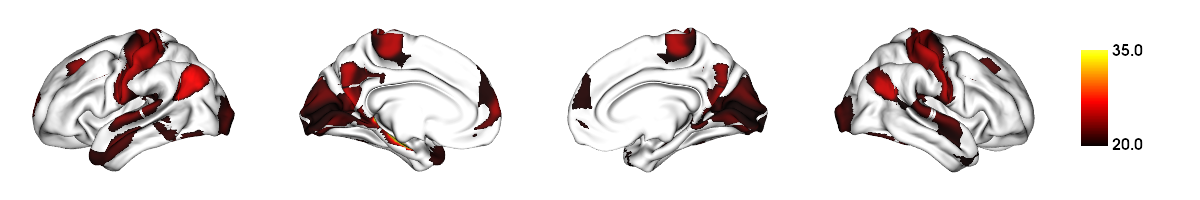

In [8]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = Tsmoo,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = plot_funcs.hotcolors, 
                 color_bar = True,
                 color_range = (20, 35),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/Tvals_cortex_LDG.svg'
                 )

## Heritability of hippocampal-isocortical functional connectivity

In [9]:
def FDR_sofie(p, q):
    # p : 1D np array, vector of p-values
    # q : float, false discovery rate level
    p = np.sort(p)
    V = len(p)
    I = np.arange(1,V+1)

    cVID = 1
    cVN  = (1 / np.arange(1,V+1)).sum()

    pID  = p[np.max(np.where(p <= (I / V*q / cVID)))]
    pN   = np.where(p <= (I / V*q / cVN))
    
    return pID, pN

## LSUB

In [10]:
tot_node_num = 360
node_str = []
for i in range(1, tot_node_num+1):
    node_str.append(i)
print(len(node_str))
node_str[0], '...', node_str[-1]

360


(1, '...', 360)

In [11]:
fname = '../solar/cortex_LSUB/CLSUB_results_herit.txt'

data = pd.read_csv(fname,
                   index_col = 0,
                   header = 0)

data.index.name = 'node'

df_data_herit = pd.DataFrame(index = node_str,
                             columns = ['H2r', 'rp'])


for nodeID in range(1, tot_node_num + 1):

    iA = data.index.get_loc(nodeID)
    iB = df_data_herit.index.get_loc(nodeID)

    df_data_herit.iloc[iB]['H2r'] = data.iloc[iA]['H2r']
    df_data_herit.iloc[iB]['rp']  = data.iloc[iA]['rp']

In [12]:
# FDR correction on p-values
H =  np.array(df_data_herit['H2r'], dtype = 'float')
p = np.array(df_data_herit['rp'], dtype = 'float')
q = 0.05
pID, pN = FDR_sofie(p, q)
pID, len(np.where(p <= pID)[0])


(0.0445605, 340)

In [13]:
# map H and p values to fsaverage
HSUB_labeled = map_to_labels(H, labeling, mask=mymask) 
HSUB_labeled_smo = mesh_smooth(HSUB_labeled.reshape(len(HSUB_labeled),1).T, D, 2)

HSUB_labeled[np.where(mymask == False)] = np.nan
HSUB_labeled_smo = HSUB_labeled_smo.reshape(HSUB_labeled_smo.shape[1],)
HSUB_labeled_smo[np.where(mymask == False)] = np.nan


pSUB_labeled = map_to_labels(p, labeling, mask=mymask) 
pSUB_labeled[np.where(mymask == False)] = np.nan

HSUB_labeled.shape, pSUB_labeled.shape, np.nanmin(HSUB_labeled), np.nanmax(HSUB_labeled)

((64984,), (64984,), 0.0322339, 0.49572879999999997)

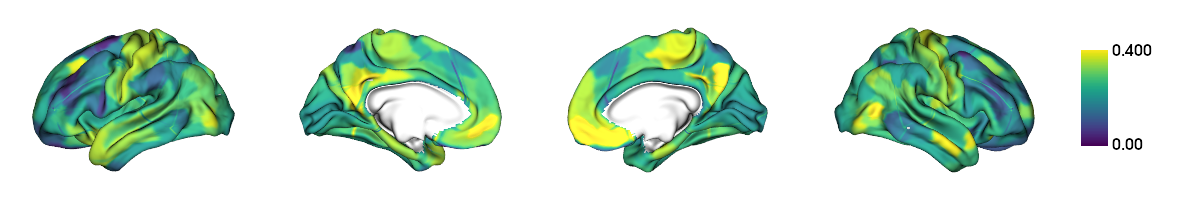

In [14]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = HSUB_labeled_smo,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'viridis', 
                 color_bar = True,
                 color_range = (0, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/cortex_herit_LSUB_smo.svg'
                 )

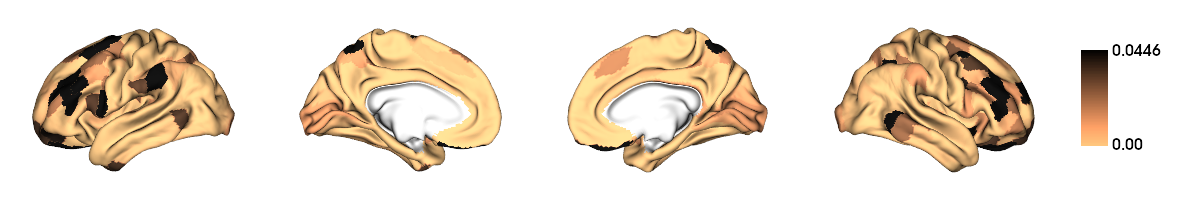

In [15]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = pSUB_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = 'copper_r',
                 color_bar = True, color_range = (0, pID), interactive = False,  zoom = 1.3,  embed_nb = True)


## LCA 

In [16]:
fname = '../solar/cortex_LCA/CLCA_results_herit.txt'
data = pd.read_csv(fname,
                   index_col = 0,
                   header = 0)
data.index.name = 'node'

In [17]:
df_data_herit = pd.DataFrame(index = node_str,
                             columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num + 1):

    iA = data.index.get_loc(nodeID)
    iB = df_data_herit.index.get_loc(nodeID)

    df_data_herit.iloc[iB]['H2r'] = data.iloc[iA]['H2r']
    df_data_herit.iloc[iB]['rp']  = data.iloc[iA]['rp']

In [18]:
# FDR correction on p-values
H =  np.array(df_data_herit['H2r'], dtype = 'float')
p = np.array(df_data_herit['rp'], dtype = 'float')
q = 0.05
pID, pN = FDR_sofie(p, q)
pID, len(np.where(p <= pID)[0])


(0.0446693, 351)

In [19]:
HCA_labeled = map_to_labels(H, labeling, mask=mymask) 
HCA_labeled_smo = mesh_smooth(HCA_labeled.reshape(len(HCA_labeled),1).T, D, 2)
HCA_labeled_smo = HCA_labeled_smo.reshape(HCA_labeled_smo.shape[1],)

HCA_labeled[np.where(mymask == False)] = np.nan
HCA_labeled_smo[np.where(mymask == False)] = np.nan

pCA_labeled = map_to_labels(p, labeling, mask=mymask) 
pCA_labeled[np.where(mymask == False)] = np.nan

HCA_labeled.shape, pCA_labeled.shape, np.nanmin(HCA_labeled), np.nanmax(HCA_labeled)

((64984,), (64984,), 0.06958500000000001, 0.5246314000000001)

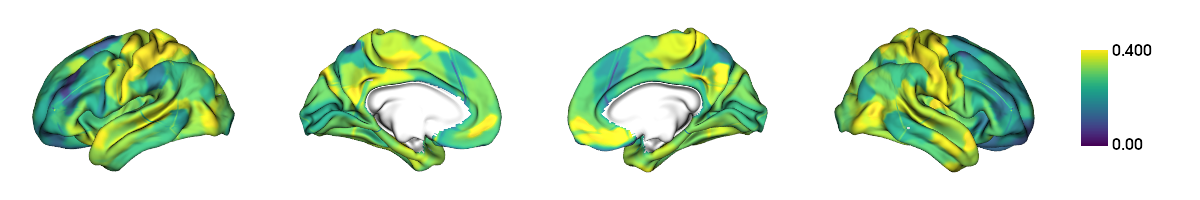

In [20]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = HCA_labeled_smo,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'viridis', 
                 color_bar = True,
                 color_range = (0, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/cortex_herit_LCA_smoo.svg'
                 )

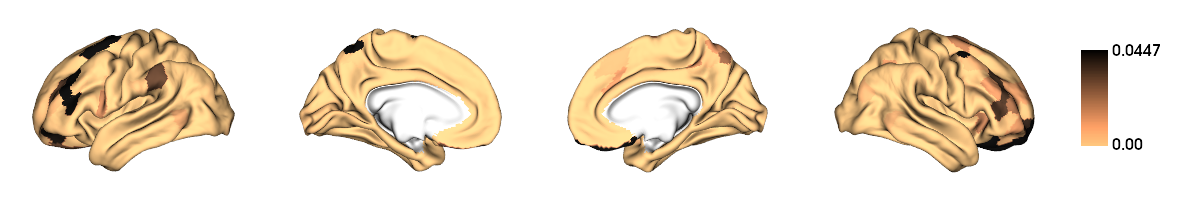

In [21]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = pCA_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'copper_r', 
                 color_bar = True,
                 color_range = (0, pID),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/cortex_herit_LCA_pvals.svg'
                 )

## LDG

In [22]:
fname = '../solar/cortex_LDG/CLDG_results_herit.txt'

data = pd.read_csv(fname,
                   index_col = 0,
                   header = 0)

data.index.name = 'node'

In [23]:
df_data_herit = pd.DataFrame(index = node_str,
                             columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num + 1):

    iA = data.index.get_loc(nodeID)
    iB = df_data_herit.index.get_loc(nodeID)

    df_data_herit.iloc[iB]['H2r'] = data.iloc[iA]['H2r']
    df_data_herit.iloc[iB]['rp']  = data.iloc[iA]['rp']

In [24]:
# FDR correction on p-values
H =  np.array(df_data_herit['H2r'], dtype = 'float')
p = np.array(df_data_herit['rp'], dtype = 'float')
q = 0.05
pID, pN = FDR_sofie(p, q)
pID, len(np.where(p <= pID)[0])


(0.045503800000000004, 358)

In [25]:
HDG_labeled = map_to_labels(H, labeling, mask=mymask) 
HDG_labeled_smo = mesh_smooth(HDG_labeled.reshape(len(HDG_labeled),1).T, D, 2)
HDG_labeled_smo = HDG_labeled_smo.reshape(HDG_labeled_smo.shape[1],)

HDG_labeled[np.where(mymask == False)] = np.nan
HDG_labeled_smo[np.where(mymask == False)] = np.nan

pDG_labeled = map_to_labels(p, labeling, mask=mymask) 
pDG_labeled[np.where(mymask == False)] = np.nan

HDG_labeled.shape, pDG_labeled.shape, np.nanmin(HDG_labeled), np.nanmax(HDG_labeled)

((64984,), (64984,), 0.0634892, 0.5007803)

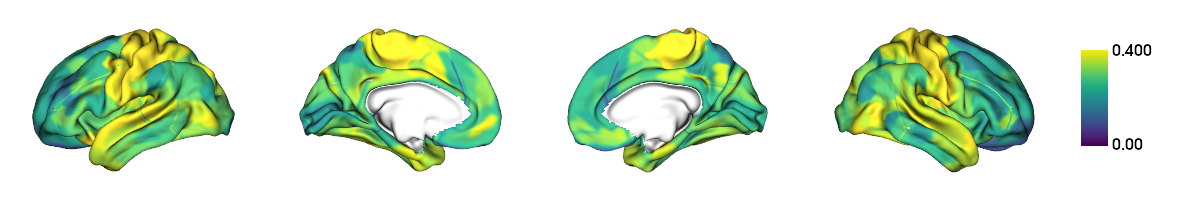

In [26]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = HDG_labeled_smo,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'viridis', 
                 color_bar = True,
                 color_range = (0, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/cortex_herit_LDG_smo.svg'
                 )

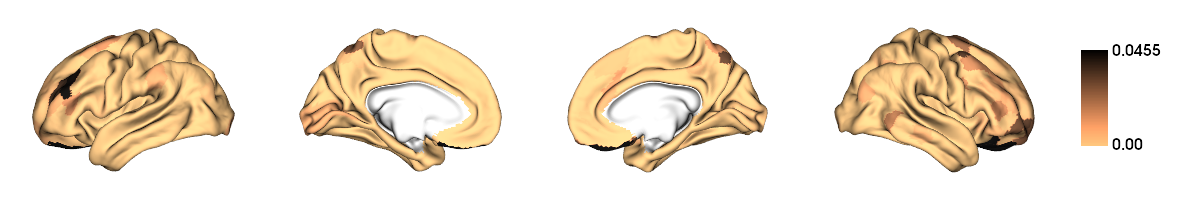

In [27]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = pDG_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'copper_r', 
                 color_bar = True,
                 color_range = (0, pID),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/cortex_herit_LDG_pvals.svg'
                 )

## distribute t-values (of functional connectivity) and heritability scores into Yeo networks

In [28]:
yeo_L_file = '../data/tout_group/lh.Yeo2011_7Networks_N1000_32k.label.gii'
yeo_R_file = '../data/tout_group/rh.Yeo2011_7Networks_N1000_32k.label.gii'
yeo_L = nb.load(yeo_L_file).agg_data()
yeo_R = nb.load(yeo_R_file).agg_data()
yeo = np.concatenate((yeo_L, yeo_R))

yeo.shape

(64984,)

# SUB (left)

In [29]:
fLSUB = '../data/tout_group/Tvals_cortex709_LSUB.h5'
h = h5py.File((fLSUB), 'r')
TdataLSUB = np.array(h['data'])
TLSUB = TdataLSUB.reshape(TdataLSUB.shape[1],)
print(TLSUB.shape)

(64984,)


In [30]:
# normalize the T-values (because H-values are all between 0 and 1)
TLSUBnorm = np.interp(TLSUB, (TLSUB.min(), TLSUB.max()), (0, 1))
TLSUBnorm[np.where(mymask == False)] = np.nan

In [31]:
# distribute T-values and heritability scores into 7 networks
df_LSUB = pd.DataFrame(index  = ['H', 'T'], 
                      columns = ['yeo1', 'yeo2', 'yeo3',
                                 'yeo4', 'yeo5', 'yeo6', 'yeo7'])

df_LSUB.at['T', 'yeo1'] = np.nanmean(TLSUBnorm[np.where(yeo==1)[0]])
df_LSUB.at['T', 'yeo2'] = np.nanmean(TLSUBnorm[np.where(yeo==2)[0]])
df_LSUB.at['T', 'yeo3'] = np.nanmean(TLSUBnorm[np.where(yeo==3)[0]])
df_LSUB.at['T', 'yeo4'] = np.nanmean(TLSUBnorm[np.where(yeo==4)[0]])
df_LSUB.at['T', 'yeo5'] = np.nanmean(TLSUBnorm[np.where(yeo==5)[0]])
df_LSUB.at['T', 'yeo6'] = np.nanmean(TLSUBnorm[np.where(yeo==6)[0]])
df_LSUB.at['T', 'yeo7'] = np.nanmean(TLSUBnorm[np.where(yeo==7)[0]])

df_LSUB.at['H', 'yeo1'] = np.nanmean(HSUB_labeled[np.where(yeo==1)[0]])
df_LSUB.at['H', 'yeo2'] = np.nanmean(HSUB_labeled[np.where(yeo==2)[0]])
df_LSUB.at['H', 'yeo3'] = np.nanmean(HSUB_labeled[np.where(yeo==3)[0]])
df_LSUB.at['H', 'yeo4'] = np.nanmean(HSUB_labeled[np.where(yeo==4)[0]])
df_LSUB.at['H', 'yeo5'] = np.nanmean(HSUB_labeled[np.where(yeo==5)[0]])
df_LSUB.at['H', 'yeo6'] = np.nanmean(HSUB_labeled[np.where(yeo==6)[0]])
df_LSUB.at['H', 'yeo7'] = np.nanmean(HSUB_labeled[np.where(yeo==7)[0]])

df_LSUB


,yeo1,yeo2,yeo3,yeo4,yeo5,yeo6,yeo7
H,0.258969,0.308922,0.219158,0.224734,0.238485,0.177307,0.286543
T,0.264297,0.283613,0.20145,0.143371,0.205047,0.176526,0.291657


In [32]:
print("VOXEL NUMBERS")
print("visual : ",  len(np.argwhere(np.isnan(TLSUBnorm[np.where(yeo==1)])==False)),
      "  SMN : ",   len(np.argwhere(np.isnan(TLSUBnorm[np.where(yeo==2)])==False)),
      "  DAN : ",   len(np.argwhere(np.isnan(TLSUBnorm[np.where(yeo==3)])==False)),
      "  VAN : " ,  len(np.argwhere(np.isnan(TLSUBnorm[np.where(yeo==4)])==False)),
      "  Limbic :", len(np.argwhere(np.isnan(TLSUBnorm[np.where(yeo==5)])==False)),
      "  FPN: ",    len(np.argwhere(np.isnan(TLSUBnorm[np.where(yeo==6)])==False)),
      "  DMN: ",    len(np.argwhere(np.isnan(TLSUBnorm[np.where(yeo==7)])==False)))

VOXEL NUMBERS
visual :  8629   SMN :  11702   DAN :  6913   VAN :  7270   Limbic : 4298   FPN:  7552   DMN:  12230


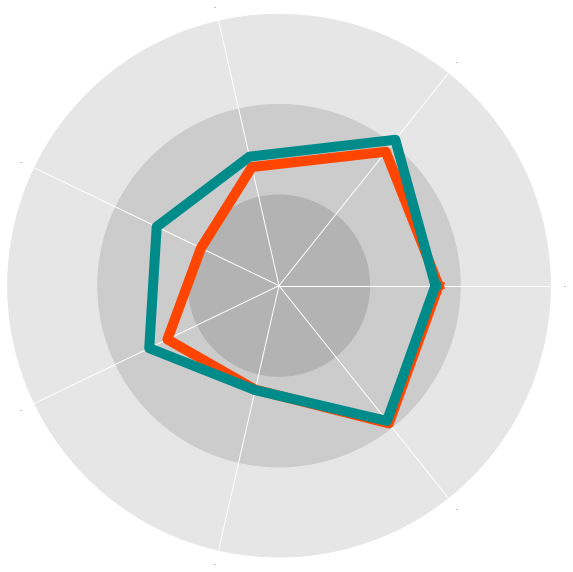

In [33]:
## Set data
dfA = pd.DataFrame({'group': df_LSUB.columns,
                   'var1':  df_LSUB.loc['T'],
                   'var2':  df_LSUB.loc['H'] })

fig = plot_funcs.make_spider_t_hvalues(dfA, 'var1', 'var2')


# CA (left)

In [34]:
fLCA = '../data/tout_group/Tvals_cortex709_LCA.h5'

h = h5py.File((fLCA), 'r')
TdataLCA = np.array(h['data'])
TLCA = TdataLCA.reshape(TdataLCA.shape[1],)
print(TLCA.shape)

# normalize the T-values (because H-values are all between 0 and 1)
TLCAnorm = np.interp(TLCA, (TLCA.min(), TLCA.max()), (0, 1))
TLCAnorm[np.where(mymask == False)] = np.nan

# distribute T-values and heritability scores into 7 networks
df_LCA = pd.DataFrame(index  = ['H', 'T'], 
                      columns = ['yeo1', 'yeo2', 'yeo3',
                                 'yeo4', 'yeo5', 'yeo6', 'yeo7'])

df_LCA.at['T', 'yeo1'] = np.nanmean(TLCAnorm[np.where(yeo==1)[0]])
df_LCA.at['T', 'yeo2'] = np.nanmean(TLCAnorm[np.where(yeo==2)[0]])
df_LCA.at['T', 'yeo3'] = np.nanmean(TLCAnorm[np.where(yeo==3)[0]])
df_LCA.at['T', 'yeo4'] = np.nanmean(TLCAnorm[np.where(yeo==4)[0]])
df_LCA.at['T', 'yeo5'] = np.nanmean(TLCAnorm[np.where(yeo==5)[0]])
df_LCA.at['T', 'yeo6'] = np.nanmean(TLCAnorm[np.where(yeo==6)[0]])
df_LCA.at['T', 'yeo7'] = np.nanmean(TLCAnorm[np.where(yeo==7)[0]])

df_LCA.at['H', 'yeo1'] = np.nanmean(HCA_labeled[np.where(yeo==1)[0]])
df_LCA.at['H', 'yeo2'] = np.nanmean(HCA_labeled[np.where(yeo==2)[0]])
df_LCA.at['H', 'yeo3'] = np.nanmean(HCA_labeled[np.where(yeo==3)[0]])
df_LCA.at['H', 'yeo4'] = np.nanmean(HCA_labeled[np.where(yeo==4)[0]])
df_LCA.at['H', 'yeo5'] = np.nanmean(HCA_labeled[np.where(yeo==5)[0]])
df_LCA.at['H', 'yeo6'] = np.nanmean(HCA_labeled[np.where(yeo==6)[0]])
df_LCA.at['H', 'yeo7'] = np.nanmean(HCA_labeled[np.where(yeo==7)[0]])

df_LCA


(64984,)


,yeo1,yeo2,yeo3,yeo4,yeo5,yeo6,yeo7
H,0.311592,0.355812,0.302544,0.269003,0.273347,0.21707,0.305292
T,0.306381,0.344179,0.249005,0.183383,0.218682,0.199987,0.304225


In [35]:
print("VOXEL NUMBERS")
print("visual : ",  len(np.argwhere(np.isnan(TLCAnorm[np.where(yeo==1)])==False)),
      "  SMN : ",   len(np.argwhere(np.isnan(TLCAnorm[np.where(yeo==2)])==False)),
      "  DAN : ",   len(np.argwhere(np.isnan(TLCAnorm[np.where(yeo==3)])==False)),
      "  VAN : " ,  len(np.argwhere(np.isnan(TLCAnorm[np.where(yeo==4)])==False)),
      "  Limbic :", len(np.argwhere(np.isnan(TLCAnorm[np.where(yeo==5)])==False)),
      "  FPN: ",    len(np.argwhere(np.isnan(TLCAnorm[np.where(yeo==6)])==False)),
      "  DMN: ",    len(np.argwhere(np.isnan(TLCAnorm[np.where(yeo==7)])==False)))

VOXEL NUMBERS
visual :  8629   SMN :  11702   DAN :  6913   VAN :  7270   Limbic : 4298   FPN:  7552   DMN:  12230


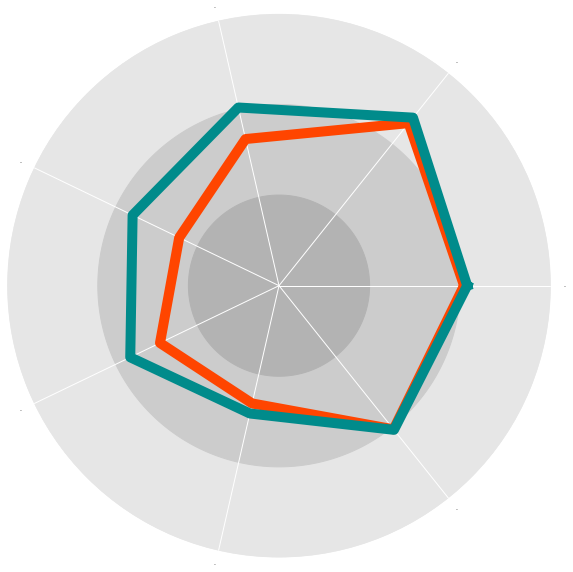

In [36]:
dfB = pd.DataFrame({'group': df_LCA.columns,
                   'var1':  df_LCA.loc['T'],
                   'var2':  df_LCA.loc['H'] })

fig = plot_funcs.make_spider_t_hvalues(dfB, 'var1', 'var2')

# DG (left)

In [37]:
fLDG = '../data/tout_group/Tvals_cortex709_LDG.h5'

h = h5py.File((fLDG), 'r')
TdataLDG = np.array(h['data'])
TLDG = TdataLDG.reshape(TdataLDG.shape[1],)
print(TLDG.shape)

# normalize the T-values (because H-values are all between 0 and 1)
TLDGnorm = np.interp(TLDG, (TLDG.min(), TLDG.max()), (0, 1))
TLDGnorm[np.where(mymask == False)] = np.nan

# distribute T-values and heritability scores into 7 networks
df_LDG = pd.DataFrame(index  = ['H', 'T'], 
                      columns = ['yeo1', 'yeo2', 'yeo3',
                                 'yeo4', 'yeo5', 'yeo6', 'yeo7'])

df_LDG.at['T', 'yeo1'] = np.nanmean(TLDGnorm[np.where(yeo==1)[0]])
df_LDG.at['T', 'yeo2'] = np.nanmean(TLDGnorm[np.where(yeo==2)[0]])
df_LDG.at['T', 'yeo3'] = np.nanmean(TLDGnorm[np.where(yeo==3)[0]])
df_LDG.at['T', 'yeo4'] = np.nanmean(TLDGnorm[np.where(yeo==4)[0]])
df_LDG.at['T', 'yeo5'] = np.nanmean(TLDGnorm[np.where(yeo==5)[0]])
df_LDG.at['T', 'yeo6'] = np.nanmean(TLDGnorm[np.where(yeo==6)[0]])
df_LDG.at['T', 'yeo7'] = np.nanmean(TLDGnorm[np.where(yeo==7)[0]])

df_LDG.at['H', 'yeo1'] = np.nanmean(HDG_labeled[np.where(yeo==1)[0]])
df_LDG.at['H', 'yeo2'] = np.nanmean(HDG_labeled[np.where(yeo==2)[0]])
df_LDG.at['H', 'yeo3'] = np.nanmean(HDG_labeled[np.where(yeo==3)[0]])
df_LDG.at['H', 'yeo4'] = np.nanmean(HDG_labeled[np.where(yeo==4)[0]])
df_LDG.at['H', 'yeo5'] = np.nanmean(HDG_labeled[np.where(yeo==5)[0]])
df_LDG.at['H', 'yeo6'] = np.nanmean(HDG_labeled[np.where(yeo==6)[0]])
df_LDG.at['H', 'yeo7'] = np.nanmean(HDG_labeled[np.where(yeo==7)[0]])

df_LDG


(64984,)


,yeo1,yeo2,yeo3,yeo4,yeo5,yeo6,yeo7
H,0.298572,0.400951,0.312358,0.290602,0.271738,0.244166,0.290163
T,0.277065,0.29829,0.230168,0.182671,0.190748,0.197147,0.266255


In [38]:
print("VOXEL NUMBERS")
print("visual : ",  len(np.argwhere(np.isnan(TLDGnorm[np.where(yeo==1)])==False)),
      "  SMN : ",   len(np.argwhere(np.isnan(TLDGnorm[np.where(yeo==2)])==False)),
      "  DAN : ",   len(np.argwhere(np.isnan(TLDGnorm[np.where(yeo==3)])==False)),
      "  VAN : " ,  len(np.argwhere(np.isnan(TLDGnorm[np.where(yeo==4)])==False)),
      "  Limbic :", len(np.argwhere(np.isnan(TLDGnorm[np.where(yeo==5)])==False)),
      "  FPN: ",    len(np.argwhere(np.isnan(TLDGnorm[np.where(yeo==6)])==False)),
      "  DMN: ",    len(np.argwhere(np.isnan(TLDGnorm[np.where(yeo==7)])==False)))

VOXEL NUMBERS
visual :  8629   SMN :  11702   DAN :  6913   VAN :  7270   Limbic : 4298   FPN:  7552   DMN:  12230


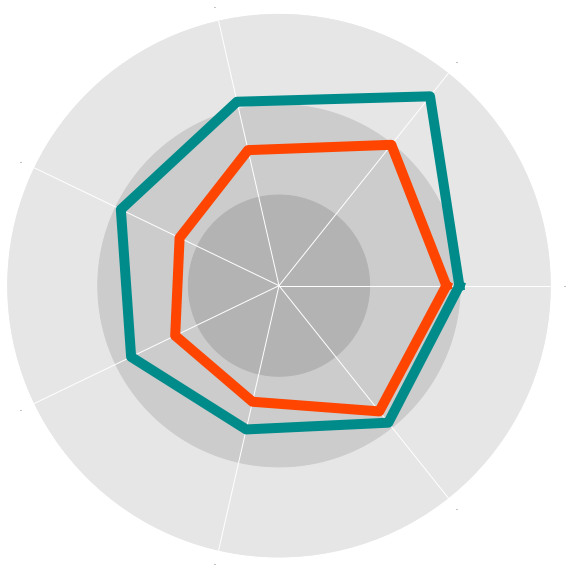

In [39]:
dfC = pd.DataFrame({'group': df_LDG.columns,
                   'var1':  df_LDG.loc['T'],
                   'var2':  df_LDG.loc['H'] })

fig = plot_funcs.make_spider_t_hvalues(dfC, 'var1', 'var2')

# Significance of heritability of subfield fc gradients

In [40]:
# read-in heritability scores from 1024 LSUB vertices
tot_node_num_lsub = 1024
node_str = []
for i in range(1, tot_node_num_lsub+1):
    node_str.append(i)
print(len(node_str))
node_str[0], '...', node_str[-1]

1024


(1, '...', 1024)

### SUB (left), heritability of G1

In [41]:
fnameLSUB = '../solar/msm50_G1_LSUB/G1_LSUB_results_herit.txt'

herit_g1_LSUB = pd.read_csv(fnameLSUB, index_col = 0, header = 0)
herit_g1_LSUB.index.name = 'node'

df_herit_g1_LSUB = pd.DataFrame(index = node_str, columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num_lsub+1):
    iA = herit_g1_LSUB.index.get_loc(nodeID)
    iB = df_herit_g1_LSUB.index.get_loc(nodeID)
    
    df_herit_g1_LSUB.iloc[iB]['H2r'] = herit_g1_LSUB.iloc[iA]['H2r']
    df_herit_g1_LSUB.iloc[iB]['rp']  = herit_g1_LSUB.iloc[iA]['rp']

sorted_herit_g1_LSUB = np.array(df_herit_g1_LSUB['H2r'], dtype = 'float')
sorted_pvals_g1_LSUB = np.array(df_herit_g1_LSUB['rp'], dtype = 'float')


q = 0.05
pID, pN = FDR_sofie(sorted_pvals_g1_LSUB, q)

pID

0.0086286

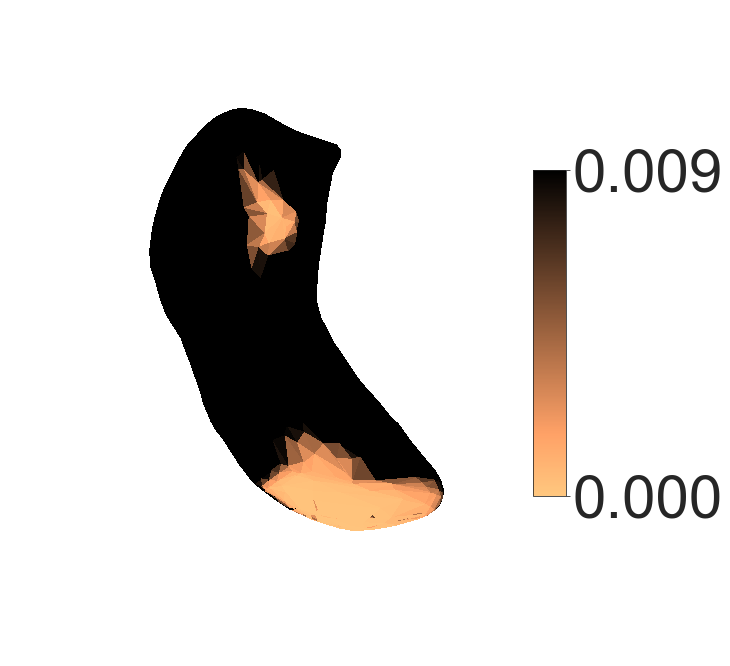

In [42]:
fig  = plot_funcs.plot_surf_upper3(plot_funcs.xLSUB, 
                                   plot_funcs.yLSUB, 
                                   plot_funcs.zLSUB, 
                                   plot_funcs.triLSUB, 
                                   sorted_pvals_g1_LSUB,
                                   'copper_r',
                                   0, pID)

In [43]:
fnameLSUB = '../solar/msm50_G2_LSUB/G2_LSUB_results_herit.txt'

herit_g2_LSUB = pd.read_csv(fnameLSUB, index_col = 0, header = 0)
herit_g2_LSUB.index.name = 'node'

df_herit_g2_LSUB = pd.DataFrame(index = node_str, columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num_lsub+1):

    iA = herit_g2_LSUB.index.get_loc(nodeID)
    iB = df_herit_g2_LSUB.index.get_loc(nodeID)

    df_herit_g2_LSUB.iloc[iB]['H2r'] = herit_g2_LSUB.iloc[iA]['H2r']
    df_herit_g2_LSUB.iloc[iB]['rp']  = herit_g2_LSUB.iloc[iA]['rp']

sorted_herit_g2_LSUB = np.array(df_herit_g2_LSUB['H2r'], dtype = 'float')
sorted_pvals_g2_LSUB = np.array(df_herit_g2_LSUB['rp'], dtype = 'float')

## there is no voxel surviving at q=0.05 !!!
q = 0.5
pID, pN = FDR_sofie(sorted_pvals_g2_LSUB, q)

pID

0.5

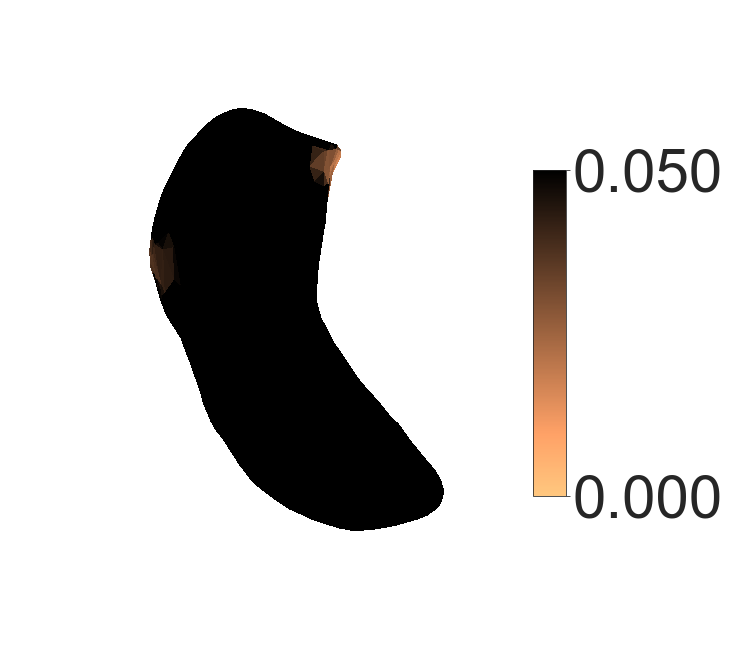

In [44]:
fig  = plot_funcs.plot_surf_upper3(plot_funcs.xLSUB, 
                                   plot_funcs.yLSUB, 
                                   plot_funcs.zLSUB, 
                                   plot_funcs.triLSUB, 
                                   sorted_pvals_g2_LSUB,
                                   'copper_r',
                                   0, 0.05)

### CA (left), heritability of G1

In [45]:
tot_node_num_lca = 2048
node_str = []
for i in range(1, tot_node_num_lca+1):
    node_str.append(i)
print(len(node_str))
node_str[0], '...', node_str[-1]

2048


(1, '...', 2048)

In [46]:
fnameLCA = '../solar/msm50_G1_LCA/G1_LCA_results_herit.txt'

herit_g1_LCA = pd.read_csv(fnameLCA, index_col = 0, header = 0)
herit_g1_LCA.index.name = 'node'

df_herit_g1_LCA = pd.DataFrame(index = node_str, columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num_lca+1):
    iA = herit_g1_LCA.index.get_loc(nodeID)
    iB = df_herit_g1_LCA.index.get_loc(nodeID)
    
    df_herit_g1_LCA.iloc[iB]['H2r'] = herit_g1_LCA.iloc[iA]['H2r']
    df_herit_g1_LCA.iloc[iB]['rp']  = herit_g1_LCA.iloc[iA]['rp']

sorted_herit_g1_LCA = np.array(df_herit_g1_LCA['H2r'], dtype = 'float')
sorted_pvals_g1_LCA = np.array(df_herit_g1_LCA['rp'], dtype = 'float')

## there is no voxel surviving at q=0.05 !!!
q = 0.5
pID, pN = FDR_sofie(sorted_pvals_g1_LCA, q)

pID

0.5

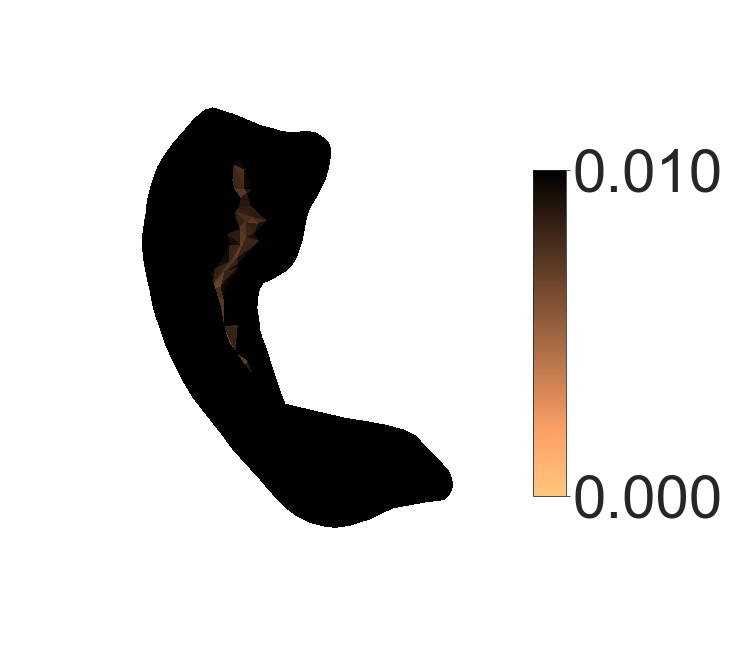

In [47]:
fig  = plot_funcs.plot_surf_upper3(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   sorted_pvals_g1_LCA,
                                   'copper_r',
                                   0, 0.01)

### CA (left), heritability of G2

In [48]:
fnameLCA = '../solar/msm50_G2_LCA/G2_LCA_results_herit.txt'

herit_g2_LCA = pd.read_csv(fnameLCA, index_col = 0, header = 0)
herit_g2_LCA.index.name = 'node'

df_herit_g2_LCA = pd.DataFrame(index = node_str, columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num_lca+1):
    iA = herit_g2_LCA.index.get_loc(nodeID)
    iB = df_herit_g2_LCA.index.get_loc(nodeID)
    
    df_herit_g2_LCA.iloc[iB]['H2r'] = herit_g2_LCA.iloc[iA]['H2r']
    df_herit_g2_LCA.iloc[iB]['rp']  = herit_g2_LCA.iloc[iA]['rp']

sorted_herit_g2_LCA = np.array(df_herit_g2_LCA['H2r'], dtype = 'float')
sorted_pvals_g2_LCA = np.array(df_herit_g2_LCA['rp'], dtype = 'float')

## there is no voxel surviving at q=0.05 !!!
q = 0.05
pID, pN = FDR_sofie(sorted_pvals_g2_LCA, q)

pID

0.0082509

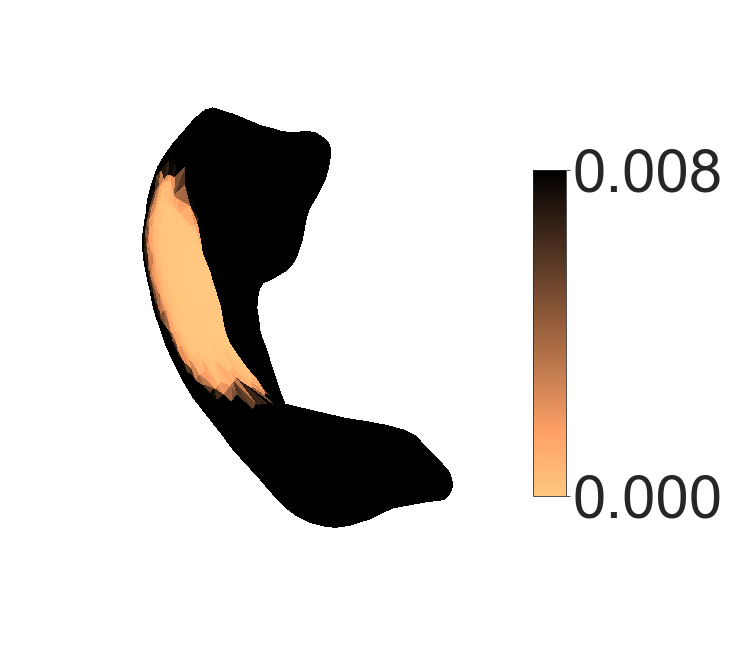

In [49]:
fig  = plot_funcs.plot_surf_upper3(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   sorted_pvals_g2_LCA,
                                   'copper_r',
                                   0, pID)

### DG (left), heritability of G1

In [50]:
tot_node_num_ldg = 1024
node_str = []
for i in range(1, tot_node_num_ldg+1):
    node_str.append(i)
print(len(node_str))
node_str[0], '...', node_str[-1]

1024


(1, '...', 1024)

In [51]:
fnameLDG = '../solar/msm50_G1_LDG/G1_LDG_results_herit.txt'

herit_g1_LDG = pd.read_csv(fnameLDG, index_col = 0, header = 0)
herit_g1_LDG.index.name = 'node'

df_herit_g1_LDG = pd.DataFrame(index = node_str, columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num_ldg+1):
    iA = herit_g1_LDG.index.get_loc(nodeID)
    iB = df_herit_g1_LDG.index.get_loc(nodeID)
    
    df_herit_g1_LDG.iloc[iB]['H2r'] = herit_g1_LDG.iloc[iA]['H2r']
    df_herit_g1_LDG.iloc[iB]['rp']  = herit_g1_LDG.iloc[iA]['rp']

sorted_herit_g1_LDG = np.array(df_herit_g1_LDG['H2r'], dtype = 'float')
sorted_pvals_g1_LDG = np.array(df_herit_g1_LDG['rp'], dtype = 'float')

## there is no voxel surviving at q=0.05 !!!
q = 0.8
pID, pN = FDR_sofie(sorted_pvals_g1_LDG, q)

pID

0.5

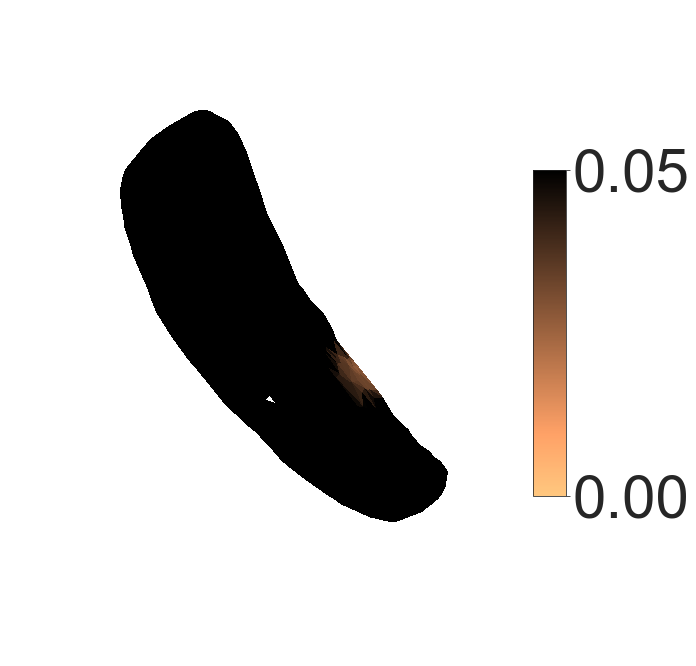

In [52]:
fig  = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   sorted_pvals_g1_LDG,
                                   'copper_r',
                                   0, 0.05)

### DG (left), heritability of G2

In [53]:
fnameLDG = '../solar/msm50_G2_LDG/G2_LDG_results_herit.txt'

herit_g2_LDG = pd.read_csv(fnameLDG, index_col = 0, header = 0)
herit_g2_LDG.index.name = 'node'

df_herit_g2_LDG = pd.DataFrame(index = node_str, columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num_ldg+1):
    iA = herit_g2_LDG.index.get_loc(nodeID)
    iB = df_herit_g2_LDG.index.get_loc(nodeID)
    
    df_herit_g2_LDG.iloc[iB]['H2r'] = herit_g2_LDG.iloc[iA]['H2r']
    df_herit_g2_LDG.iloc[iB]['rp']  = herit_g2_LDG.iloc[iA]['rp']

sorted_herit_g2_LDG = np.array(df_herit_g2_LDG['H2r'], dtype = 'float')
sorted_pvals_g2_LDG = np.array(df_herit_g2_LDG['rp'], dtype = 'float')

## there is no voxel surviving at q=0.05 !!!
q = 0.8
pID, pN = FDR_sofie(sorted_pvals_g2_LDG, q)

pID

0.5

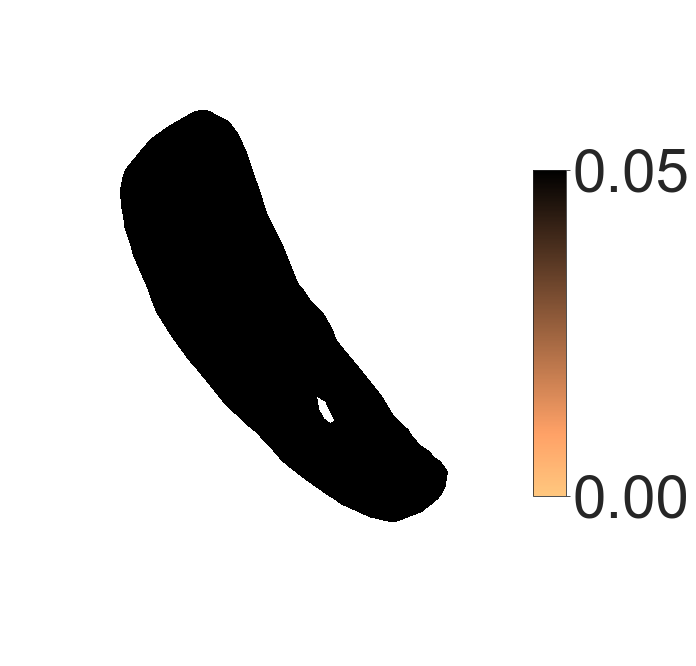

In [54]:
fig  = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   sorted_pvals_g2_LDG,
                                   'copper_r',
                                   0, 0.05)